In [1]:
import os
os.chdir('/home')

from warnings import filterwarnings
filterwarnings('ignore', module='skimage')

import numpy as np
import pandas as pd
import gym

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from kerasgym.models import cnn_model_base, dense_model_base, DDPGModel, DQNModel
from kerasgym.agents import Agent
from kerasgym.agents.processing import downsample, rgb_to_binary
from kerasgym.agents.processing import stack_consecutive, combine_consecutive
from kerasgym.agents.schedules import LinearDecay, ScopingPeriodic
from kerasgym.agents.actors import EpsilonGreedyActor
from keras.optimizers import RMSprop, Adam

from kerasgym.agents.schedules import graph_schedule

Using TensorFlow backend.


In [2]:
# CARTPOLE

env = gym.make('CartPole-v1')
env.reset()

base_config = {
    'in_shape': env.observation_space.shape,
    'layer_sizes': [64, 32, 16],
    'activation': 'relu'
}
base_model = dense_model_base(**base_config)

dqn_config = {
    'gamma': 0.99,
    'tau': 1.0,
    'optimizer': Adam(lr=0.001)
}
model = DQNModel(base_model, **dqn_config)

schedule = LinearDecay(1.0, 0.1, 500, -1)
actor = EpsilonGreedyActor(epsilon_schedule=schedule)
buffer_size = 10000
batch_size = 32

agent = Agent(env, state_pipeline=[], model=model, actor=actor, 
              buffer_size=buffer_size, batch_size=batch_size,
              report_freq=10, warmup_length=0)
agent.reset()
#agent.run_episode()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
agent.run_indefinitely()

End of episode 10. Last 10 episodes: Average reward: 17.7. Average duration: 17.7.
End of episode 20. Last 10 episodes: Average reward: 20.6. Average duration: 20.6.
End of episode 30. Last 10 episodes: Average reward: 22.2. Average duration: 22.2.
End of episode 40. Last 10 episodes: Average reward: 19.4. Average duration: 19.4.
End of episode 50. Last 10 episodes: Average reward: 28.7. Average duration: 28.7.
End of episode 60. Last 10 episodes: Average reward: 19.6. Average duration: 19.6.
End of episode 70. Last 10 episodes: Average reward: 23.4. Average duration: 23.4.
End of episode 80. Last 10 episodes: Average reward: 29.2. Average duration: 29.2.
End of episode 90. Last 10 episodes: Average reward: 20.6. Average duration: 20.6.
End of episode 100. Last 10 episodes: Average reward: 23.1. Average duration: 23.1.
End of episode 110. Last 10 episodes: Average reward: 27.5. Average duration: 27.5.
End of episode 120. Last 10 episodes: Average reward: 28.4. Average duration: 28.4.
E

0

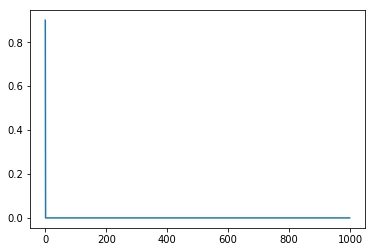

In [23]:
s = LinearDecay(0.9, 0.1, 0.0001)
graph_schedule(s, 1000)
s.t

In [2]:
s = ScopingPeriodic(0.9, 0.1, 10000)

In [10]:
s._periodic(1000)

0.3987268717780482

In [ ]:
# MOUNTAIN CAR

env = gym.make('MountainCarContinuous-v0')
env.reset()

base_config = {
    'in_shape': env.observation_space.shape,
    'layer_sizes': [16, 16],
    'activation': 'relu'
}

base_model = dense_model_base(**base_config)

ddpg_config = {
    'action_dim': env.ac`tion_space.shape[0],
    'actor_activation': 'softmax',
    'gamma': 0.99,
    'tau': 0.125,
    'actor_alpha': 1e-3,
    'critic_alpha': 1e-3
}
model = DDPGModel(base_model, **ddpg_config)

schedule = LinearDecay(1.0, 0.1, 500, -1)
explorer = EpsilonGreedy(schedule, discrete=False)
buffer_size = 10000
batch_size = 32

agent = Agent(env,
              state_processing_fns=[],
              model=model, ptoc_fn=lambda x,y: return x,
              ctol_fn=lambda x,y: return x,
              explorer=explorer, buffer_size=buffer_size,
              batch_size=batch_size, warmup_length=0)
agent.reset()
agent.run_indefinitely()

In [ ]:
# BREAKOUT

# env
env = gym.make('BreakoutDeterministic-v4')
env.reset()

# custom shape due to downsampling and stacking
shape = (105, 80, 4)

# model
base_config = {
    'in_shape': shape,
    'conv_layer_sizes': [16, 32],
    'fc_layer_sizes': [256],
    'kernel_sizes': [(8,8), (4,4)],
    'strides': [(4,4), (2,2)],
    'activation': 'relu'
}

base_model = cnn_model_base(**base_config)

dqn_config = {
    'action_dim': env.action_space.n,
    'gamma': 0.99,
    'tau': 0.15,
    'optimizer': RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
}
model = DQNModel(base_model, **dqn_config)

schedule = LinearDecay(1.0, 0.1, 1000000, interval=1)
explorer = EpsilonGreedy(schedule)
buffer_size = 100000
batch_size = 32

agent = Agent(env,
              state_processing_fns=[downsample(shape[:-1]), rgb_to_binary(),
                                    #combine_consecutive(fun='diff'),
                                    stack_consecutive(4)],
              model=model, ptoc_fn=argmax_scalar(),
              ctol_fn=scalar_to_onehot(),
              explorer=explorer, buffer_size=buffer_size,
              batch_size=batch_size, warmup_length=50000,
              state_dtype=np.uint8)
agent.reset()

In [ ]:
agent.run_indefinitely()